## EDA and Data

conda env: `s-sr-2023`

[Data Link](https://solafune.com/ja/competitions/7a1fc5e3-49bd-4ec1-8378-974951398c98?menu=data&tab=)


## Basic

In [1]:
!python -V
# !which python

Python 3.8.15


## Data

In [5]:
!mkdir ../../data/

mkdir: ディレクトリ `../../data/' を作成できません: ファイルが存在します


## Folder

```log
data
├── test
│   ├── *_high.tif
│   ├── *_low.tif
│   └── test.zip
├── train
│   ├── *_high.tif
│   ├── *_low.tif
│   └── train.zip
└── uploadsample
    ├── *_high.tif
    ├── *_low.tif
    └── uploadsample.zip
```

## Import

In [1]:
from typing import Union
from pathlib import Path
import warnings
import random
from pprint import pprint
from glob import glob
import json
import os
import sys 
import shutil
import collections as cl
from math import trunc
from operator import itemgetter
from dataclasses import dataclass
from joblib import Parallel, delayed

from PIL import Image
from tqdm import tqdm
import numpy as np
import tifffile
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from box import Box
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30
Image.MAX_IMAGE_PIXELS = int(1e6 ** 2)

# インライン表示
%matplotlib inline

In [2]:
@dataclass
class CFG(object):
    
    # data
    DATA_ROOT: str = '../../data'
    ROOT_TRAIN: str = f'{DATA_ROOT}/train'
    ROOT_TEST: str = f'{DATA_ROOT}/test'
    ROOT_SAMPLE: str = f'{DATA_ROOT}/uploadsample'
    
    # output
    OUTPUT_DIR: str = f'output/001/'

cfg = Box({k:v for k, v in CFG().__dict__.items() if not '__' in k})
pprint(cfg)

{'DATA_ROOT': '../../data',
 'OUTPUT_DIR': 'output/001/',
 'ROOT_SAMPLE': '../../data/uploadsample',
 'ROOT_TEST': '../../data/test',
 'ROOT_TRAIN': '../../data/train'}


In [3]:
PATHS_HIGH_TRAIN = sorted(glob(f'{cfg.ROOT_TRAIN}/train_*_high.tif'))
PATHS_LOW_TRAIN = sorted(glob(f'{cfg.ROOT_TRAIN}/train_*_low.tif'))
PATHS_HIGH_TRAIN[:4], PATHS_LOW_TRAIN[:4]

(['../../data/train/train_0_high.tif',
  '../../data/train/train_1000_high.tif',
  '../../data/train/train_1001_high.tif',
  '../../data/train/train_1002_high.tif'],
 ['../../data/train/train_0_low.tif',
  '../../data/train/train_1000_low.tif',
  '../../data/train/train_1001_low.tif',
  '../../data/train/train_1002_low.tif'])

(650, 650, 3) uint8


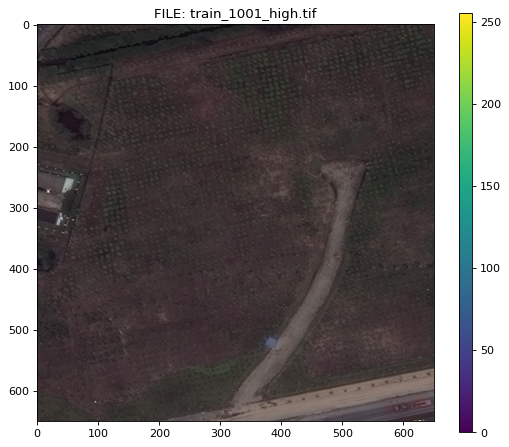

In [4]:
IDX = 2
PATH_IMG = PATHS_HIGH_TRAIN[IDX]
fname = os.path.basename(PATH_IMG)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

img = tifffile.imread(PATH_IMG)
print(img.shape, img.dtype)

plt.figure(figsize=(8, 8), facecolor='white', dpi=80)
plt.title(f'FILE: {fname}')
plt.imshow(img)
plt.colorbar(shrink=0.85, aspect=30, orientation='vertical')
plt.savefig(f'{cfg.OUTPUT_DIR}sample_idx{IDX}_name{fname}.png')
plt.show();

In [5]:
df = pd.DataFrame({
    'path_high': PATHS_HIGH_TRAIN, 
    'path_low': PATHS_LOW_TRAIN
    })
display(df.sample(4))

def load_image_info(row):
    P_H = row.path_high
    img_h = tifffile.imread(P_H)
    h_H, w_H, _ = img_h.shape
    dtype_h = img.dtype
    
    
    P_L = row.path_low
    img_l = tifffile.imread(P_L)
    h_L, w_L, _ = img_l.shape
    dtype_l = img.dtype
    
    return h_H, w_H, dtype_h, \
        img_h[:,:, 0].mean(), img_h[:,:, 0].std(), \
        img_h[:,:, 1].mean(), img_h[:,:, 1].std(), \
        img_h[:,:, 2].mean(), img_h[:,:, 2].std(), \
        h_L, w_L, dtype_l,\
        img_l[:,:, 0].mean(), img_l[:,:, 0].std(), \
        img_l[:,:, 1].mean(), img_l[:,:, 1].std(), \
        img_l[:,:, 2].mean(), img_l[:,:, 2].std()

meta_columns = [f'{reso}_{feat}' for reso in ['high', 'low'] for feat in 
                ['hight', 'width', 'dtype', 
                 'r_mean', 'r_std',
                 'g_mean', 'g_std',
                 'b_mean', 'b_std',
                 ]]

tqdm.pandas()
df[meta_columns] = df.progress_apply(load_image_info, axis=1, result_type='expand')
    

path_high  \
2726   ../../data/train/train_754_high.tif   
1850  ../../data/train/train_2666_high.tif   
382   ../../data/train/train_1344_high.tif   
1345  ../../data/train/train_2210_high.tif   

                                 path_low  
2726   ../../data/train/train_754_low.tif  
1850  ../../data/train/train_2666_low.tif  
382   ../../data/train/train_1344_low.tif  
1345  ../../data/train/train_2210_low.tif

100%|██████████| 3000/3000 [00:10<00:00, 273.00it/s]


In [6]:
df.head(2)

path_high                             path_low  \
0     ../../data/train/train_0_high.tif     ../../data/train/train_0_low.tif   
1  ../../data/train/train_1000_high.tif  ../../data/train/train_1000_low.tif   

   high_hight  high_width high_dtype  high_r_mean  high_r_std  high_g_mean  \
0         650         650      uint8    45.250045   13.765331    46.895564   
1         650         650      uint8    45.298123   23.020507    49.475520   

   high_g_std  high_b_mean  high_b_std  low_hight  low_width low_dtype  \
0   13.728972    46.593484   13.723393        130        130     uint8   
1   18.634012    49.695782   18.504302        130        130     uint8   

   low_r_mean  low_r_std  low_g_mean  low_g_std  low_b_mean  low_b_std  
0   45.249408   6.478374   46.895148   6.534679   46.592663   6.380026  
1   45.299290  21.654118   49.468047  16.306142   49.690059  16.145339

In [7]:
df.to_csv(f'{cfg.DATA_ROOT}/train.csv', index=False, header=True)

<Figure size 640x640 with 0 Axes>

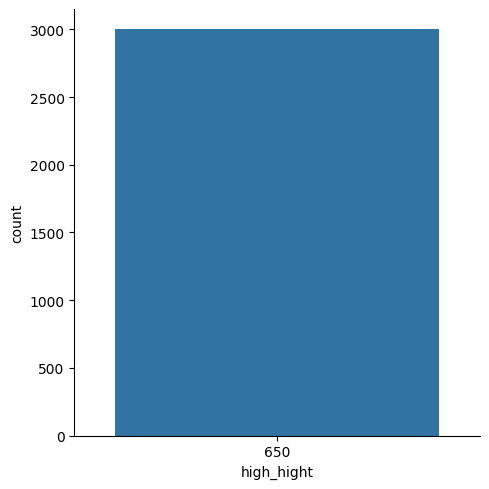

<Figure size 640x640 with 0 Axes>

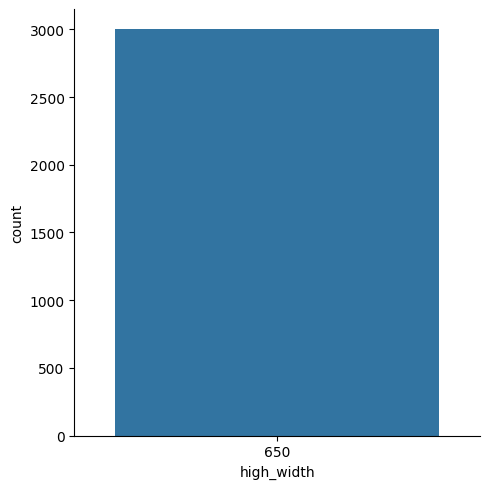

<Figure size 640x640 with 0 Axes>

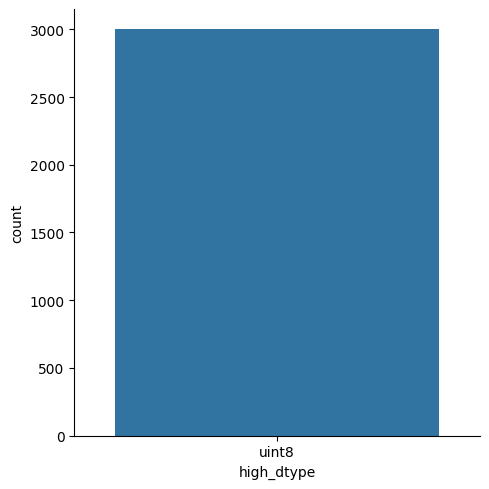

<Figure size 640x640 with 0 Axes>

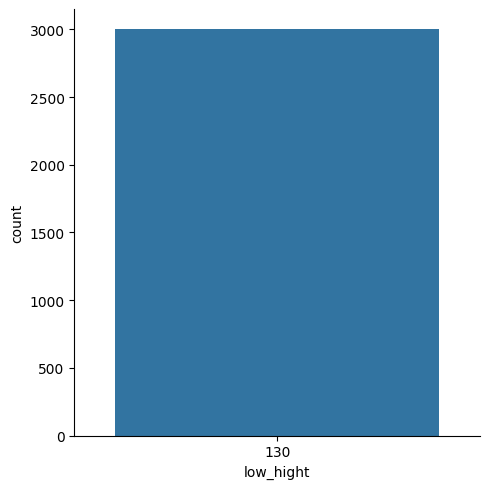

<Figure size 640x640 with 0 Axes>

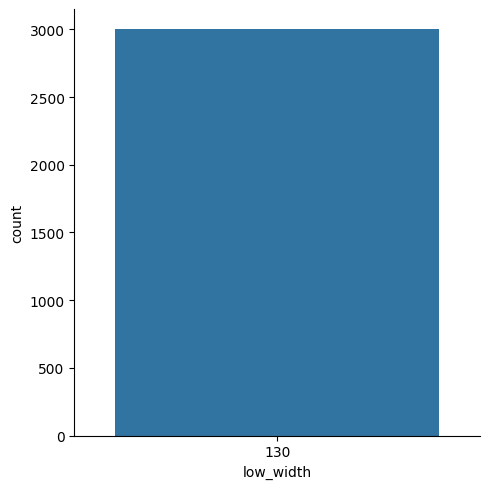

<Figure size 640x640 with 0 Axes>

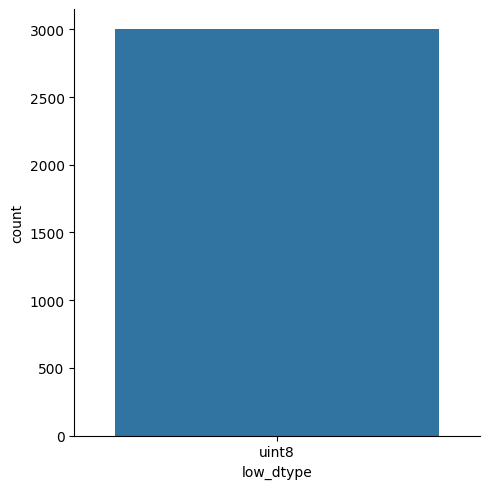

In [7]:
for col in ['high_hight',
  'high_width',
  'high_dtype',
  'low_hight',
  'low_width',
  'low_dtype',]:
    plt.figure(figsize=(8, 8), facecolor='white', dpi=80)
    sns.catplot(x=col, data=df, kind="count")
    plt.savefig(f'{cfg.OUTPUT_DIR}countplot_C{col}.png')
    plt.show();

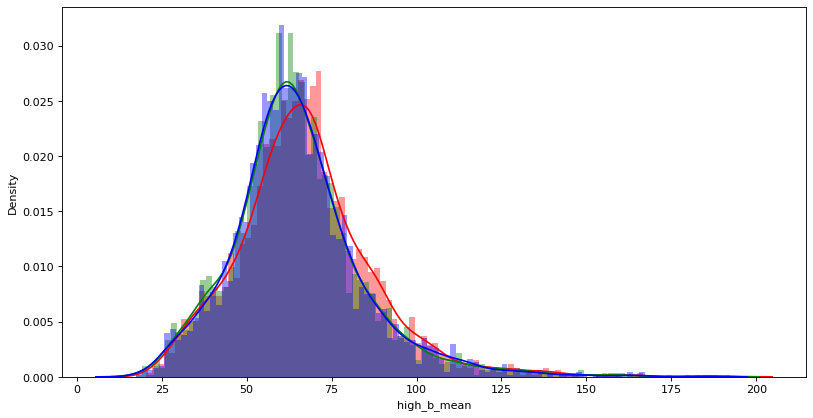

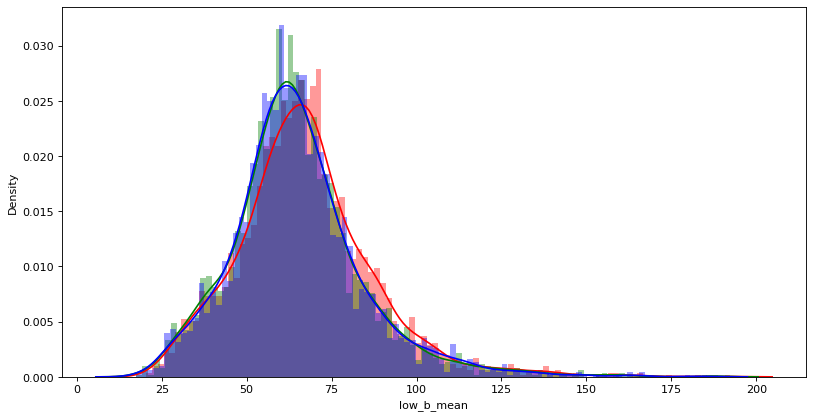

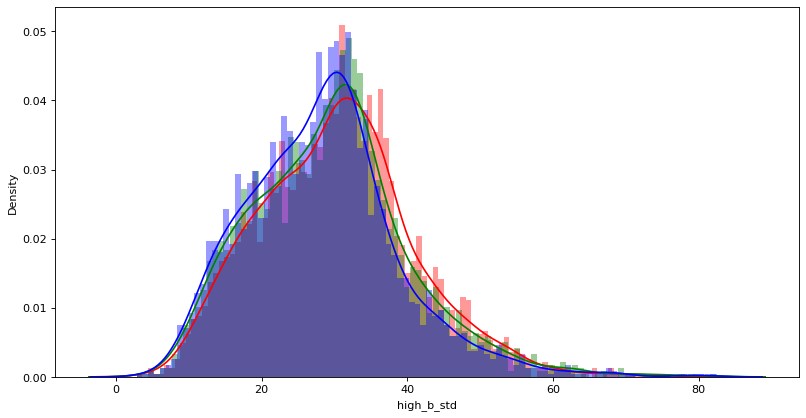

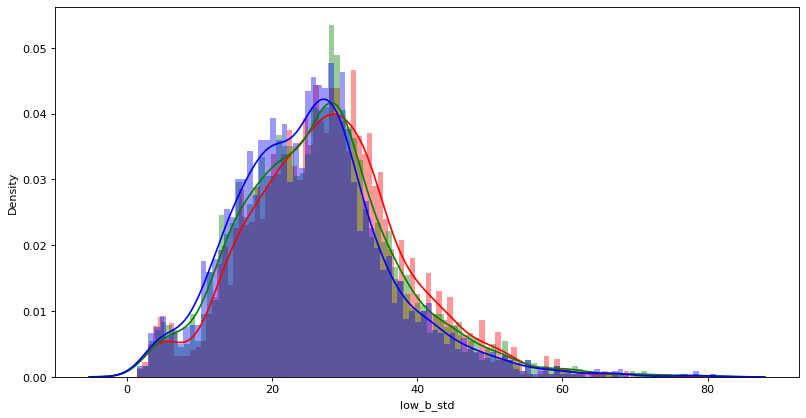

In [8]:
for stat in ['mean', 'std']:
    for reso in ['high', 'low']:
        plt.figure(figsize=(12, 6), facecolor='white', dpi=80)
        for c in ['r', 'g', 'b']:
            col = f'{reso}_{c}_{stat}'
            sns.distplot(df[col], label=f'C:{c} Reso:{reso}', color=c, bins=100)
        plt.savefig(f'{cfg.OUTPUT_DIR}countplot_{reso}_{stat}.png')
        plt.show();

<Figure size 960x480 with 0 Axes>

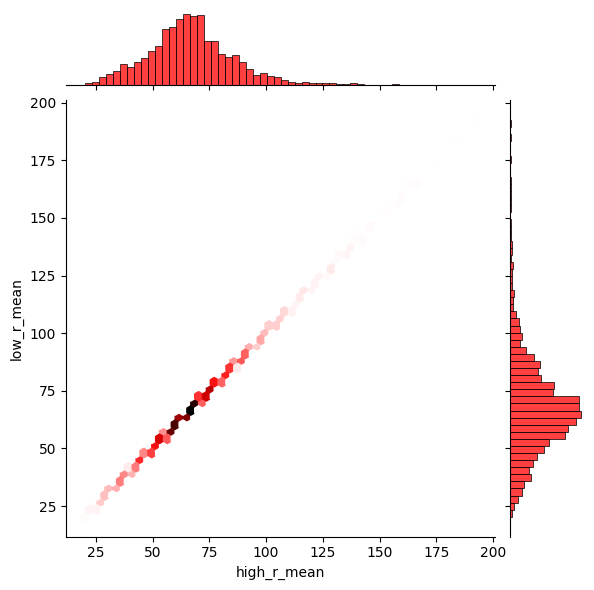

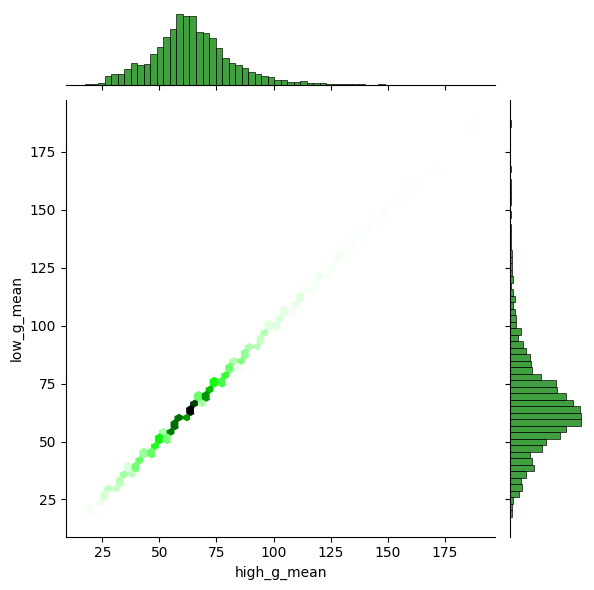

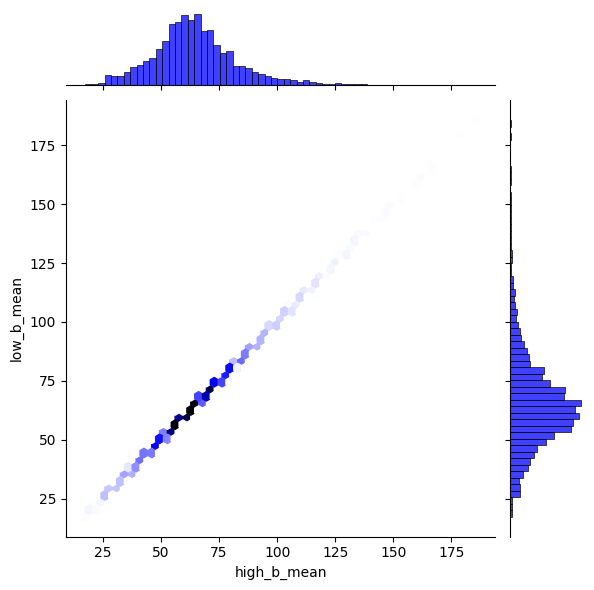

<Figure size 960x480 with 0 Axes>

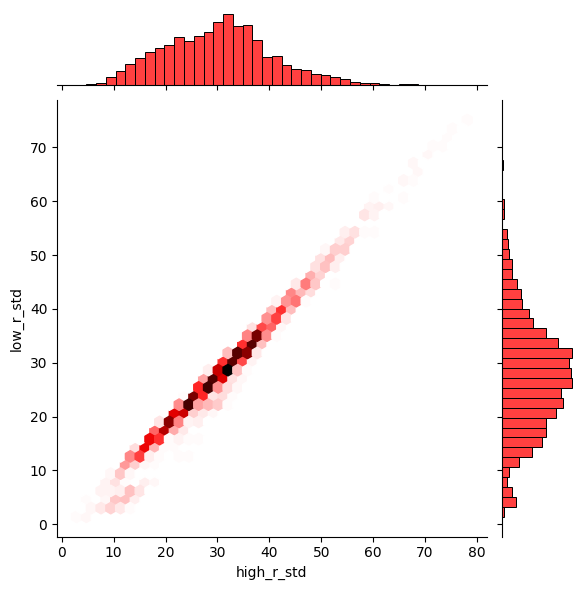

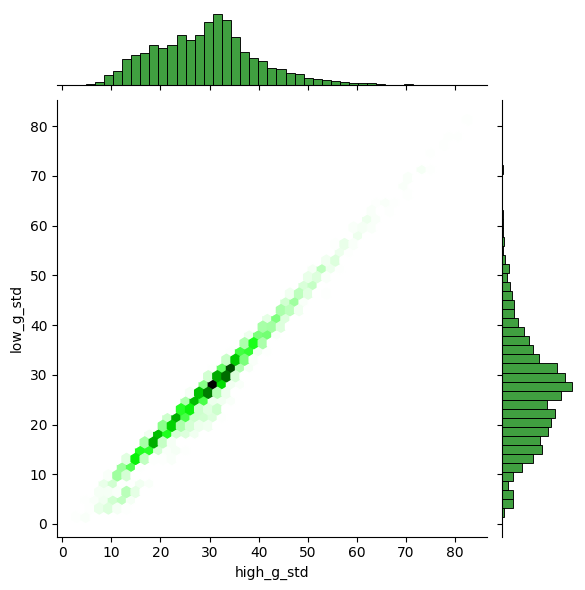

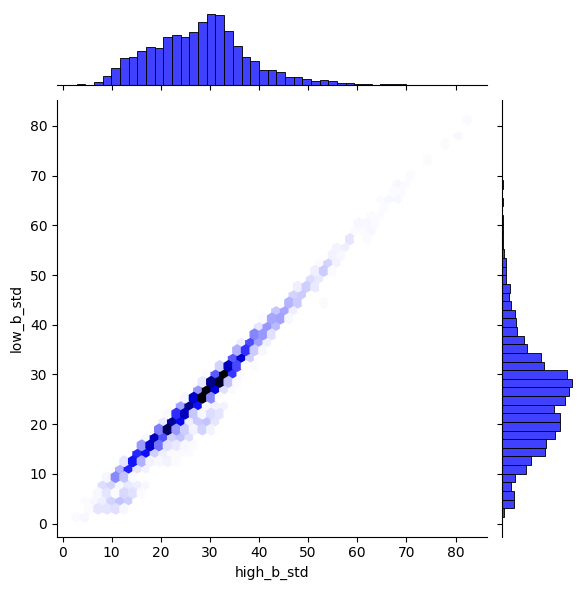

In [9]:
for stat in ['mean', 'std']:
    plt.figure(figsize=(12, 6), facecolor='white', dpi=80)
    for c in ['r', 'g', 'b']:
        col = f'{reso}_{c}_{stat}'
        sns.jointplot(x=f'high_{c}_{stat}', y=f'low_{c}_{stat}', data=df, kind='hex', color=c)
    plt.savefig(f'{cfg.OUTPUT_DIR}hexplot_{reso}_{stat}.png')
    plt.show();

<Figure size 960x480 with 0 Axes>

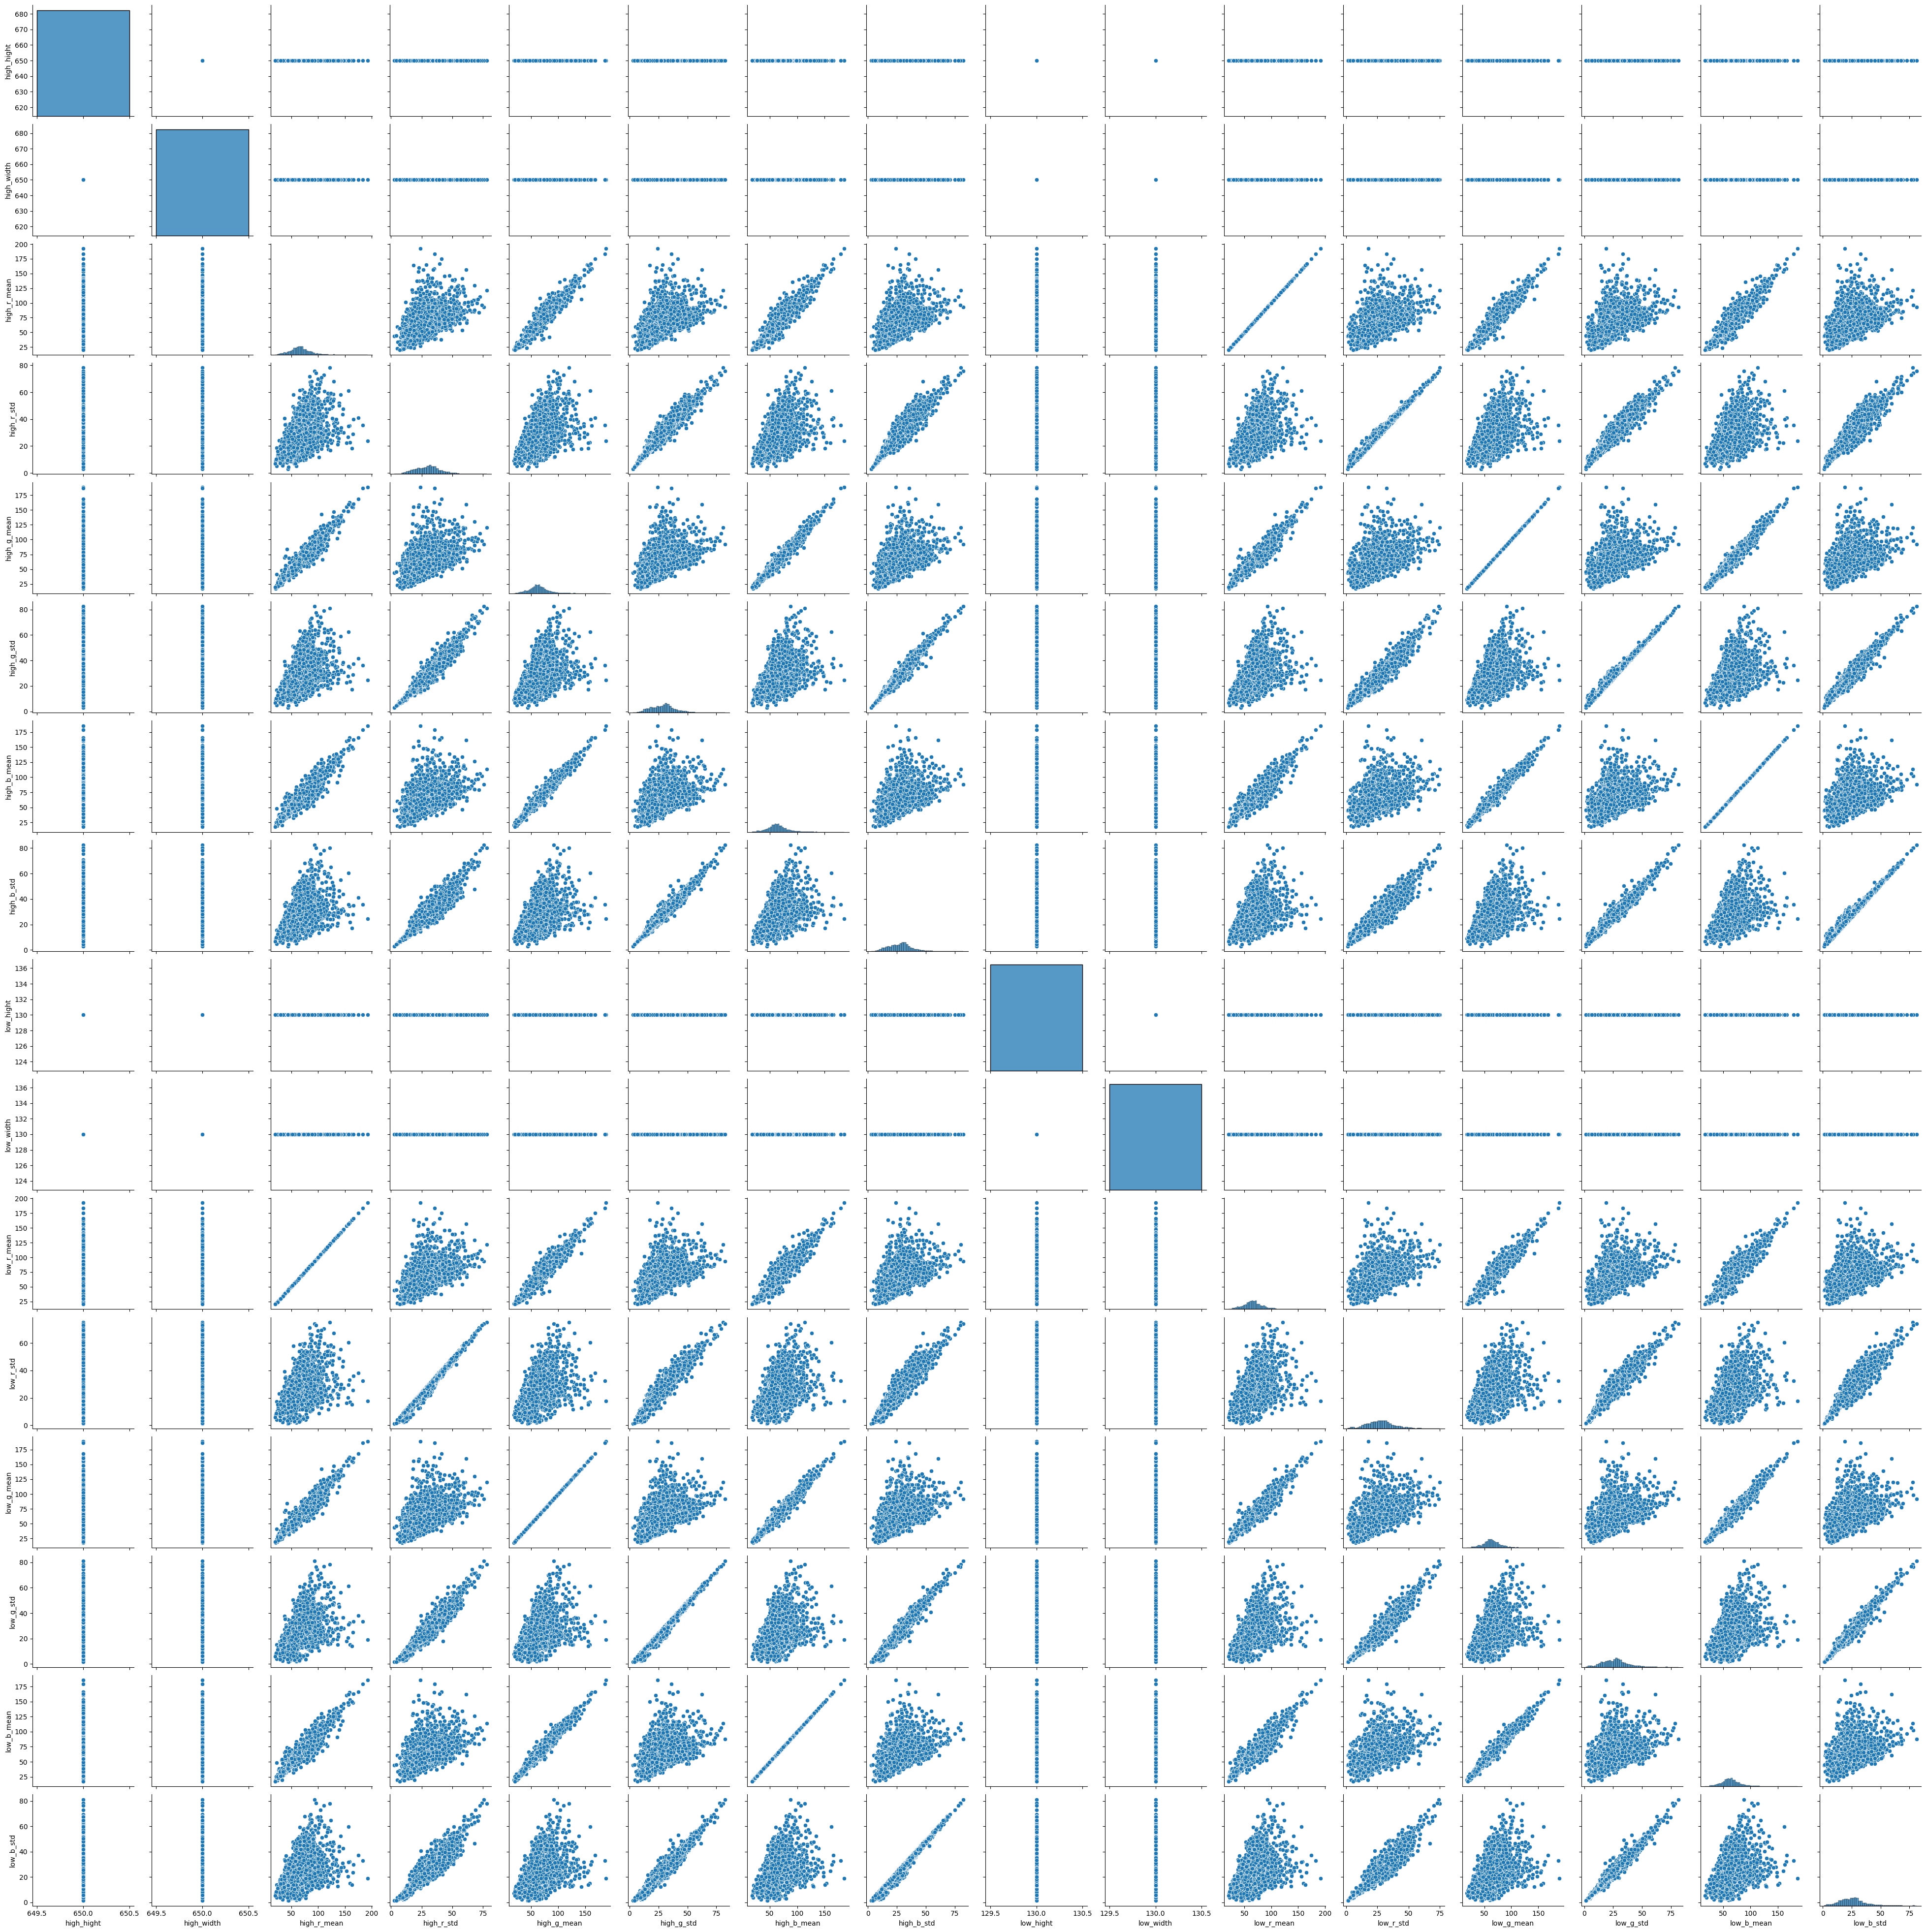

In [10]:
plt.figure(figsize=(12, 6), facecolor='white', dpi=80)
sns.pairplot(data=df)
plt.savefig(f'{cfg.OUTPUT_DIR}apirplot_all.png')
plt.show();